This notebook contains three sections: 1) Fit a spectral peak from Lynx DSA data (digital spectrum analyzer) , 2) Perform energy calibration, 3) Read data from CAEN N957 MCA (analog multichannel analyzer)

# 1 - Fit a spectral peak from Lynx DSA

### First we load libraries

In [2]:
########################################################
# Created on Feb 9 2021                                #
# Modified   Feb 8 2022
# @author: Manel Errando (errando@physics.wustl.edu)   #
# based on code by Zach Hughes                         #
########################################################


# Import modules.
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from ast import literal_eval as le
from sys import exit as ex

# Use the seaborn style sheet. Uncomment if you don't like, or add your own customization.
#plt.style.use('seaborn')

# This will make the plots look nice
plt.rcParams['font.size'] = 12
plt.rcParams['font.family'] = 'Roboto'
plt.rcParams['figure.dpi'] = 200
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.major.size'] = 8.0
plt.rcParams['xtick.minor.size'] = 4.0

plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.major.size'] = 8.0
plt.rcParams['ytick.minor.size'] = 4.0

### The following block loads data from the Lynx MCA
The data is stored in two arrays: *ch* and *counts* containing respectively the channel numbers and the number of counts per channel.

In [3]:
# This code block reads data saved from the Lynx DSA
data_file = './am_spec.csv'

# Read spectral file, it expects 7 lines of header and one final footer line, which are skipped
ch,en,counts = np.genfromtxt(data_file,skip_header=7,skip_footer=1,delimiter=',',unpack='true')

### This block plots the contents of the *counts* array
This shows the spectrum we obtained

findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Roboto'] not found. Falling back to DejaVu Sans.


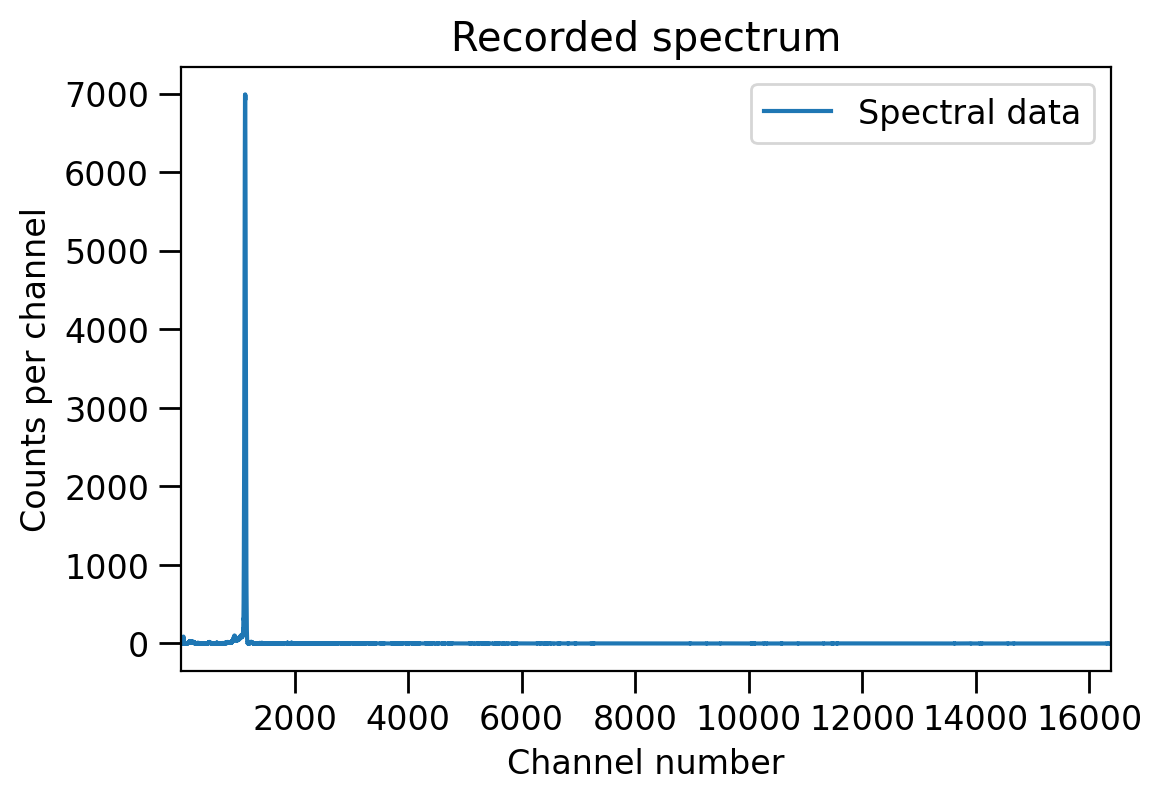

In [4]:
# Set up plot window.
f, ax = plt.subplots()
ax.set_title('Recorded spectrum')
ax.set_ylabel('Counts per channel')

ax.plot(counts, label='Spectral data') # Plots the contents of the counts array
xStart = ch[0]
xEnd = ch[len(ch)-1]
ax.set_xlabel('Channel number')

ax.set_xlim([xStart, xEnd])

plt.legend()
plt.show(block=False) # Don't block terminal by default.

### In the following we define a gaussian function and fit it to one of the spectral peaks

In [5]:
# We define a Gaussian function
# Using definition: https://en.wikipedia.org/wiki/Gaussian_function
def gaussianFunction(x, a, b, c, d):
   return a * np.exp(-(x-b)**2/(2*c**2)) + d


Now we fit a gaussian to one of the peaks. First look by eye and set the range of channels you want to use for the fit. We will plot the peak to be able to estimate the fit parameters:

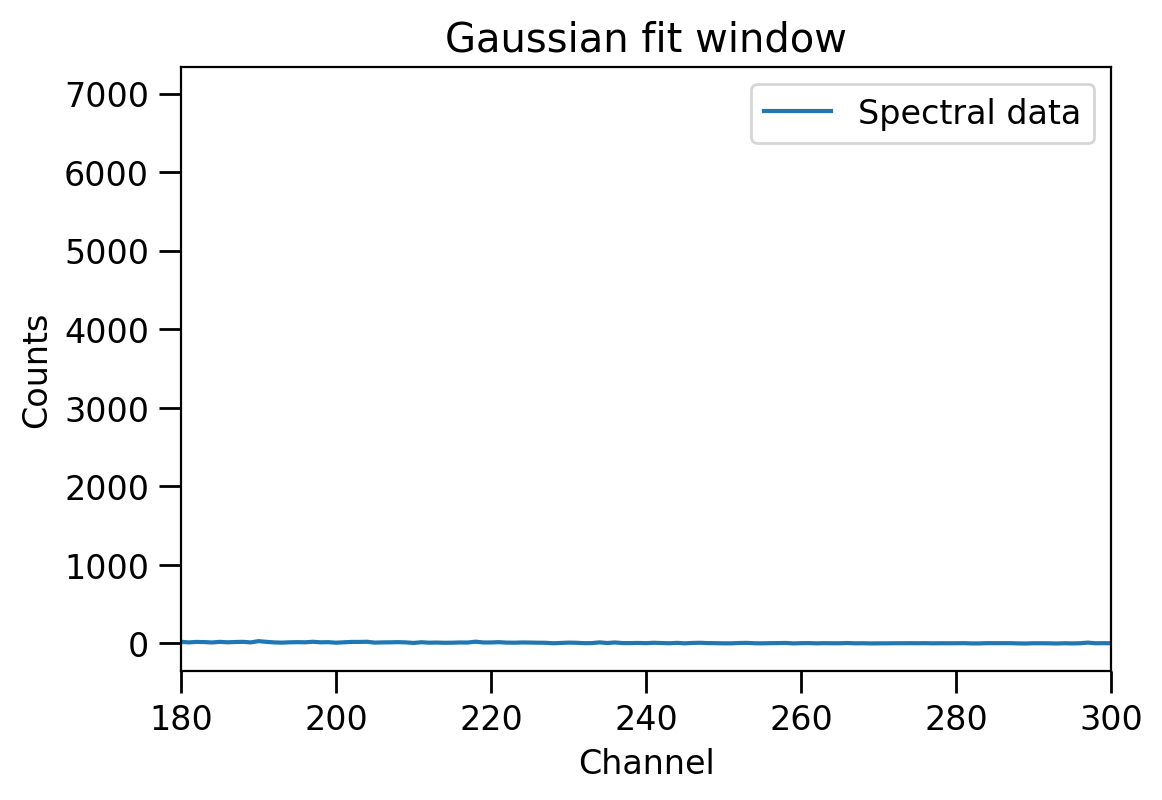

In [ ]:
ZoomLeft  = 180 # lower bound for the gaussian fit
ZoomRight = 300 # upper bound for the gaussian fit

# Now we plot that region of the spectrum

popt, pcov = None, None
n = 1000 # How many points to plot in the model fit.

# Set up plot window.
f, ax = plt.subplots()
ax.plot(counts, label='Spectral data')
ax.set_title('Gaussian fit window')
ax.set_xlabel('Channel')
ax.set_ylabel('Counts')

# User looks by eye for where to fit the peak.
#lowerBound = enterNumeric('Enter the lower bound for the gaussian fit: ')
#upperBound = enterNumeric('Enter the upper bound for the gaussian fit: ')
ax.set_xlim(ZoomLeft, ZoomRight)

plt.legend()
plt.show(block=False)

#


Now we need to select the range of channels where the function looks gaussian and make accurate guesses for the amplitude of the gaussian, the position of the gaussian peak, the standard deviation, and the Y axis offset (basically the baseline that the gaussian is sitting on top of)

Fitting complete. Optimized values: 
Peak amplitude: 	 6929.0  +/- 15.3
Peak location: 		 1129.4  +/- 0.0
Standard deviation: 	 11.2  +/- 0.0
Y axis Offset: 		 51.3  +/- 6.0
Covariance Matrix: 
[[ 2.35052536e+02  3.48651512e-07 -1.76385220e-01 -2.53414380e+01]
 [ 3.48651512e-07  7.59268067e-04 -5.76800749e-10  3.68100463e-09]
 [-1.76385220e-01 -5.76800749e-10  9.47245375e-04 -8.20777881e-02]
 [-2.53414380e+01  3.68100463e-09 -8.20777881e-02  3.58381749e+01]]


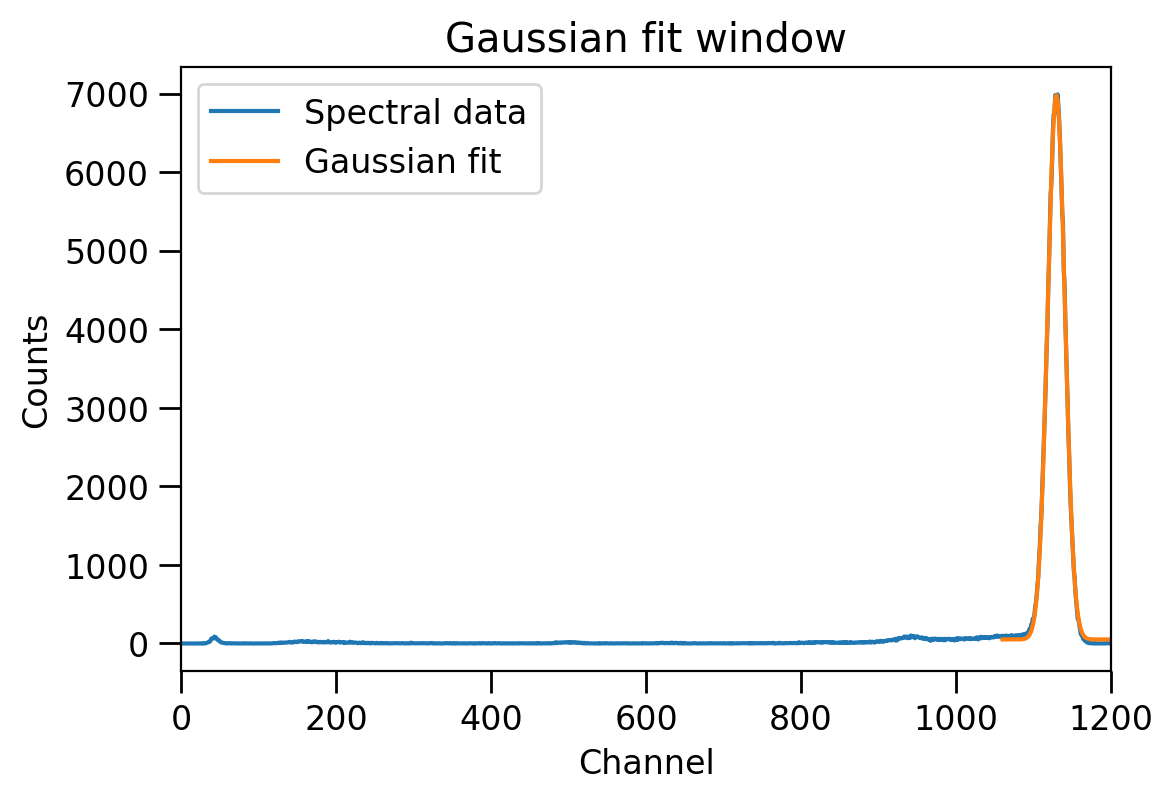

In [7]:
# Boundaries of the fit in channel number
lowerBound = 1060 # lower bound for the gaussian fit
upperBound = 1200 # upper bound for the gaussian fit


#Using Gaussian definition: a * np.exp(-(x-b)**2/(2*c**2)) + d
guessA = 7050   # estimate for the amplitude at the peak, in counts
guessB = 1130   # estimate for the position pf the peak, in channel number
guessC = 20    # estimate for the standard deviation, in channels (~ half of the FWHM)
guessD = 10   # estimate for Y offset or baseline, in counts

# Set up plot window.
f, ax = plt.subplots()
ax.plot(counts, label='Spectral data')
ax.set_title('Gaussian fit window')
ax.set_xlabel('Channel')
ax.set_ylabel('Counts')
ax.set_xlim(ZoomLeft, ZoomRight)

# Restrict the fit region to user bounds.
p0 = [guessA, guessB, guessC, guessD]
xData = np.arange(lowerBound, upperBound)
yData = counts[lowerBound:upperBound]

# Do the fit.
try:
   popt, pcov = curve_fit(gaussianFunction, xData, yData, p0=p0)
   perr = np.sqrt(np.diag(pcov))
except Exception as e:
   print(e)
   print('Something went wrong with the fit. Did it not converge?')

# If it was successful, print it out and update the plot.
if popt is not None:
   print('Fitting complete. Optimized values: ')
   print('Peak amplitude: \t',     "{:.1f}".format(popt[0]), ' +/-', "{:.1f}".format(perr[0]))
   print('Peak location: \t\t',    "{:.1f}".format(popt[1]), ' +/-', "{:.1f}".format(perr[1]))
   print('Standard deviation: \t', "{:.1f}".format(popt[2]), ' +/-', "{:.1f}".format(perr[2]))
   print('Y axis Offset: \t\t',    "{:.1f}".format(popt[3]), ' +/-', "{:.1f}".format(perr[3]))
   print('Covariance Matrix: ')
   print(pcov)
   xModel = np.linspace(lowerBound, upperBound, n)
   yModel = gaussianFunction(xModel, *popt)
   ax.plot(xModel, yModel, label='Gaussian fit')
   plt.legend()
   plt.show()

In [8]:
print(popt)

[6928.9649048  1129.37940012   11.22103468   51.25901358]
